In [ ]:
# Install dependencies
!pip install --quiet kaggle
!pip install --quiet segmentation-models-pytorch --no-deps
!pip install --quiet albumentations
!pip install --quiet matplotlib scikit-learn
print("Libraries installed sucessfully !")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.2 MB/s eta 0:00:00
Libraries installed sucessfully !


In [ ]:
from google.colab import files
import os

# Upload kaggle.json
print("Upload kaggle.json file:")
files.upload()

# Setup kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




Upload kaggle.json file:


Saving kaggle.json to kaggle.json


In [ ]:
# Download dataset
# REPLACE with your actual dataset slug
dataset_slug = "omendrakumarupadhyay/crack-segmentation-datasetimage-mask"
!kaggle datasets download -d {dataset_slug}


Dataset URL: https://www.kaggle.com/datasets/omendrakumarupadhyay/crack-segmentation-datasetimage-mask
License(s): CC0-1.0


In [ ]:
!unzip -q *.zip -d Crack_Dataset
print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


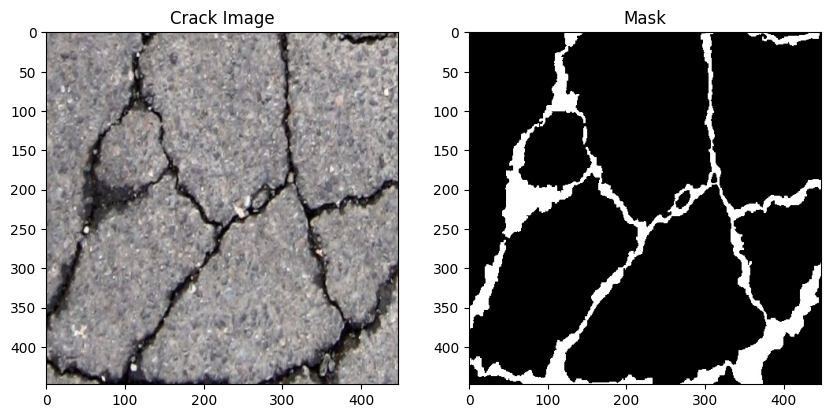

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import glob

image_paths = sorted(glob.glob('Crack_Dataset/Complete Dataset/images/*.jpg'))
mask_paths = sorted(glob.glob('Crack_Dataset/Complete Dataset/masks/*.jpg'))

idx = random.randint(0, len(image_paths)-1)
image = Image.open(image_paths[idx])
mask = Image.open(mask_paths[idx])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Crack Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()


Check all images and masks resolution

In [ ]:
sizes = set()
for img_path, mask_path in zip(image_paths, mask_paths):
    img_size = Image.open(img_path).size
    mask_size = Image.open(mask_path).size
    sizes.add((img_size, mask_size))

print(f"Unique (Image, Mask) sizes found: {len(sizes)}")
print(sizes)


Unique (Image, Mask) sizes found: 1
{((448, 448), (448, 448))}


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CrackDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [ ]:
# 80% Train, 10% Val, 10% Test
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

train_loader = DataLoader(CrackDataset(train_imgs, train_masks, transform), batch_size=8, shuffle=True)
val_loader = DataLoader(CrackDataset(val_imgs, val_masks, transform), batch_size=8, shuffle=False)
test_loader = DataLoader(CrackDataset(test_imgs, test_masks, transform), batch_size=8, shuffle=False)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")


Train: 9038, Val: 1130, Test: 1130


In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.PSPNet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
epochs=50
# Create checkpoint directory in Google Drive
checkpoint_dir = "/content/drive/MyDrive/CS_PSPnet_checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []
val_losses = []

print("🚀 Starting training...\n")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_loss = 0

    print(f"\n📘 Epoch {epoch+1}/{epochs}")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"✅ Training loss: {avg_train_loss:.4f}")

    # Validation step
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"🔍 Validation loss: {avg_val_loss:.4f}")

    # Save model checkpoint
    checkpoint_path = f"{checkpoint_dir}/pspnet_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"💾 Model checkpoint saved at: {checkpoint_path}")


🚀 Starting training...


📘 Epoch 1/50


✅ Training loss: 0.0883
🔍 Validation loss: 0.0710
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_1.pth

📘 Epoch 2/50


✅ Training loss: 0.0661
🔍 Validation loss: 0.0647
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_2.pth

📘 Epoch 3/50


✅ Training loss: 0.0617
🔍 Validation loss: 0.0626
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_3.pth

📘 Epoch 4/50


✅ Training loss: 0.0585
🔍 Validation loss: 0.0617
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_4.pth

📘 Epoch 5/50


✅ Training loss: 0.0563
🔍 Validation loss: 0.0589
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_5.pth

📘 Epoch 6/50


✅ Training loss: 0.0542
🔍 Validation loss: 0.0584
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_6.pth

📘 Epoch 7/50


✅ Training loss: 0.0526
🔍 Validation loss: 0.0584
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_7.pth

📘 Epoch 8/50


✅ Training loss: 0.0510
🔍 Validation loss: 0.0575
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_8.pth

📘 Epoch 9/50


✅ Training loss: 0.0498
🔍 Validation loss: 0.0568
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_9.pth

📘 Epoch 10/50


✅ Training loss: 0.0486
🔍 Validation loss: 0.0566
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_10.pth

📘 Epoch 11/50


✅ Training loss: 0.0475
🔍 Validation loss: 0.0580
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_11.pth

📘 Epoch 12/50


✅ Training loss: 0.0468
🔍 Validation loss: 0.0586
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_12.pth

📘 Epoch 13/50


✅ Training loss: 0.0458
🔍 Validation loss: 0.0575
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_13.pth

📘 Epoch 14/50


✅ Training loss: 0.0449
🔍 Validation loss: 0.0582
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_14.pth

📘 Epoch 15/50


✅ Training loss: 0.0443
🔍 Validation loss: 0.0574
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_15.pth

📘 Epoch 16/50


✅ Training loss: 0.0438
🔍 Validation loss: 0.0590
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_16.pth

📘 Epoch 17/50


✅ Training loss: 0.0429
🔍 Validation loss: 0.0577
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_17.pth

📘 Epoch 18/50


✅ Training loss: 0.0425
🔍 Validation loss: 0.0592
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_18.pth

📘 Epoch 19/50


✅ Training loss: 0.0419
🔍 Validation loss: 0.0620
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_19.pth

📘 Epoch 20/50


✅ Training loss: 0.0416
🔍 Validation loss: 0.0592
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_20.pth

📘 Epoch 21/50


✅ Training loss: 0.0409
🔍 Validation loss: 0.0627
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_21.pth

📘 Epoch 22/50


✅ Training loss: 0.0407
🔍 Validation loss: 0.0626
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_22.pth

📘 Epoch 23/50


✅ Training loss: 0.0404
🔍 Validation loss: 0.0645
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_23.pth

📘 Epoch 24/50


✅ Training loss: 0.0396
🔍 Validation loss: 0.0643
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_24.pth

📘 Epoch 25/50


✅ Training loss: 0.0394
🔍 Validation loss: 0.0647
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_25.pth

📘 Epoch 26/50


✅ Training loss: 0.0391
🔍 Validation loss: 0.0610
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_26.pth

📘 Epoch 27/50


✅ Training loss: 0.0389
🔍 Validation loss: 0.0623
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_27.pth

📘 Epoch 28/50


✅ Training loss: 0.0383
🔍 Validation loss: 0.0691
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_28.pth

📘 Epoch 29/50


✅ Training loss: 0.0381
🔍 Validation loss: 0.0666
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_29.pth

📘 Epoch 30/50


✅ Training loss: 0.0378
🔍 Validation loss: 0.0705
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_30.pth

📘 Epoch 31/50


✅ Training loss: 0.0377
🔍 Validation loss: 0.0626
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_31.pth

📘 Epoch 32/50


✅ Training loss: 0.0375
🔍 Validation loss: 0.0671
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_32.pth

📘 Epoch 33/50


✅ Training loss: 0.0371
🔍 Validation loss: 0.0645
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_33.pth

📘 Epoch 34/50


✅ Training loss: 0.0368
🔍 Validation loss: 0.0660
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_34.pth

📘 Epoch 35/50


✅ Training loss: 0.0366
🔍 Validation loss: 0.0715
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_35.pth

📘 Epoch 36/50


✅ Training loss: 0.0363
🔍 Validation loss: 0.0645
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_36.pth

📘 Epoch 37/50


✅ Training loss: 0.0362
🔍 Validation loss: 0.0688
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_37.pth

📘 Epoch 38/50


✅ Training loss: 0.0361
🔍 Validation loss: 0.0662
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_38.pth

📘 Epoch 39/50


✅ Training loss: 0.0359
🔍 Validation loss: 0.0703
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_39.pth

📘 Epoch 40/50


✅ Training loss: 0.0358
🔍 Validation loss: 0.0722
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_40.pth

📘 Epoch 41/50


✅ Training loss: 0.0354
🔍 Validation loss: 0.0717
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_41.pth

📘 Epoch 42/50


✅ Training loss: 0.0353
🔍 Validation loss: 0.0727
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_42.pth

📘 Epoch 43/50


✅ Training loss: 0.0351
🔍 Validation loss: 0.0727
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_43.pth

📘 Epoch 44/50


✅ Training loss: 0.0348
🔍 Validation loss: 0.0703
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_44.pth

📘 Epoch 45/50


✅ Training loss: 0.0348
🔍 Validation loss: 0.0711
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_45.pth

📘 Epoch 46/50


✅ Training loss: 0.0346
🔍 Validation loss: 0.0714
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_46.pth

📘 Epoch 47/50


✅ Training loss: 0.0345
🔍 Validation loss: 0.0731
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_47.pth

📘 Epoch 48/50


✅ Training loss: 0.0344
🔍 Validation loss: 0.0746
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_48.pth

📘 Epoch 49/50


✅ Training loss: 0.0342
🔍 Validation loss: 0.0758
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_49.pth

📘 Epoch 50/50


✅ Training loss: 0.0341
🔍 Validation loss: 0.0751
💾 Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_50.pth


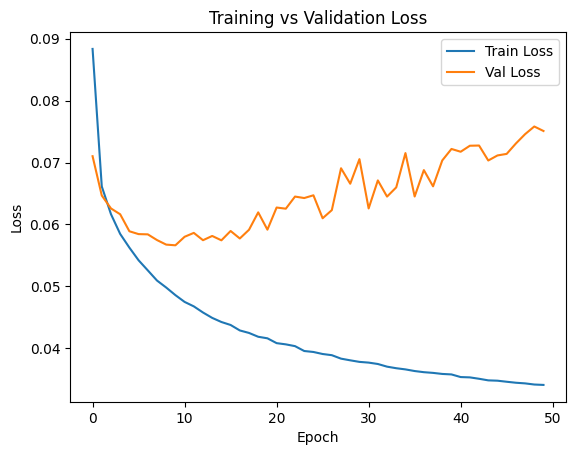

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    jaccard_score,
)

# Suppose preds and masks are already available from model inference
preds = torch.sigmoid(preds)           # Ensure values between 0 and 1
preds = (preds > 0.5).float()          # Convert to binary mask

# Flatten predictions and targets
y_true = masks.cpu().numpy().flatten()
y_pred = preds.cpu().numpy().flatten()

# Convert to integers
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)

# Now calculate metrics
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("IoU Score:", jaccard_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


Confusion Matrix:
 [[89219 41331]
 [  509    13]]
IoU Score: 0.0003106109478412539
Precision: 0.00031443498452012384
Recall: 0.02490421455938697
F1 Score: 0.0006210289972770267
Accuracy: 0.6807861328125


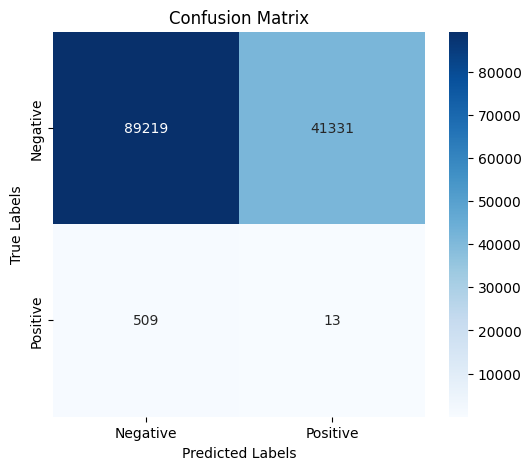

Accuracy: 0.6808
Precision: 0.0003
Recall: 0.0249
F1 Score: 0.0006
IoU (Jaccard Index): 0.0003


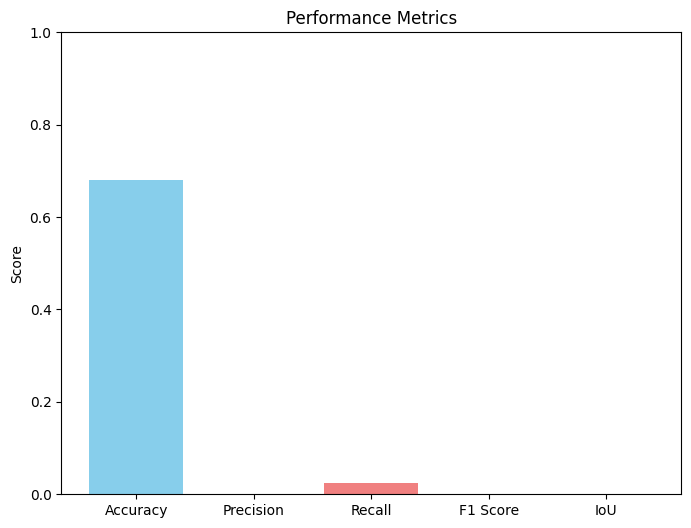

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Provided values
cm = np.array([[89219, 41331],
               [  509,    13]])

iou = 0.0003106109478412539
precision = 0.00031443498452012384
recall = 0.02490421455938697
f1 = 0.0006210289972770267
accuracy = 0.6807861328125

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")

# Optional: Plot performance metrics in a bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'IoU']
values = [accuracy, precision, recall, f1, iou]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightgoldenrodyellow'])
plt.ylim(0, 1)
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.show()


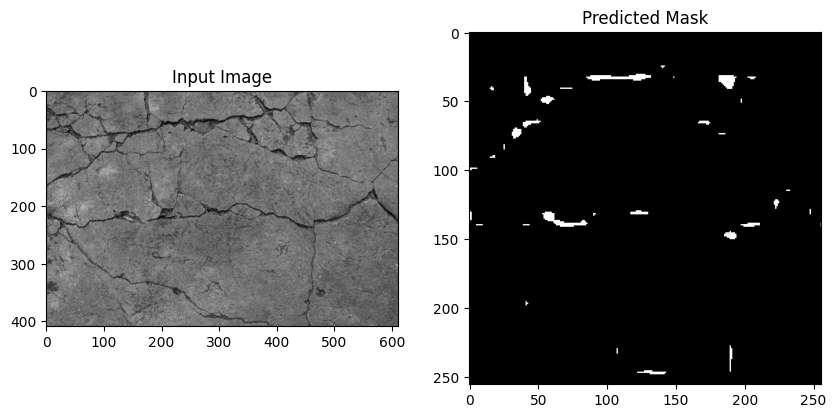

In [ ]:
def predict_mask(image_path, model, device):
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Predict mask
    with torch.no_grad():
        output = model(img_tensor)
        pred_mask = (output.squeeze().cpu().numpy() > 0.5).astype('float32')

    # Show input and predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

# Use it like this (replace with your own image path if needed):
predict_mask("/content/sample 3.jpg", model, device) # Repalce input image path


In [ ]:
# Save final model after training
torch.save(model.state_dict(), "pspnet_trained_model.pth")
print("✅ Model saved as pspnet_trained_model.pth")


✅ Model saved as pspnet_trained_model.pth


In [ ]:
from google.colab import files
files.download("pspnet_trained_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>